PyTorch version: 2.9.0+cu126
CUDA available: True
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

First training example:
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}

Training samples: 120000

Label distribution:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64


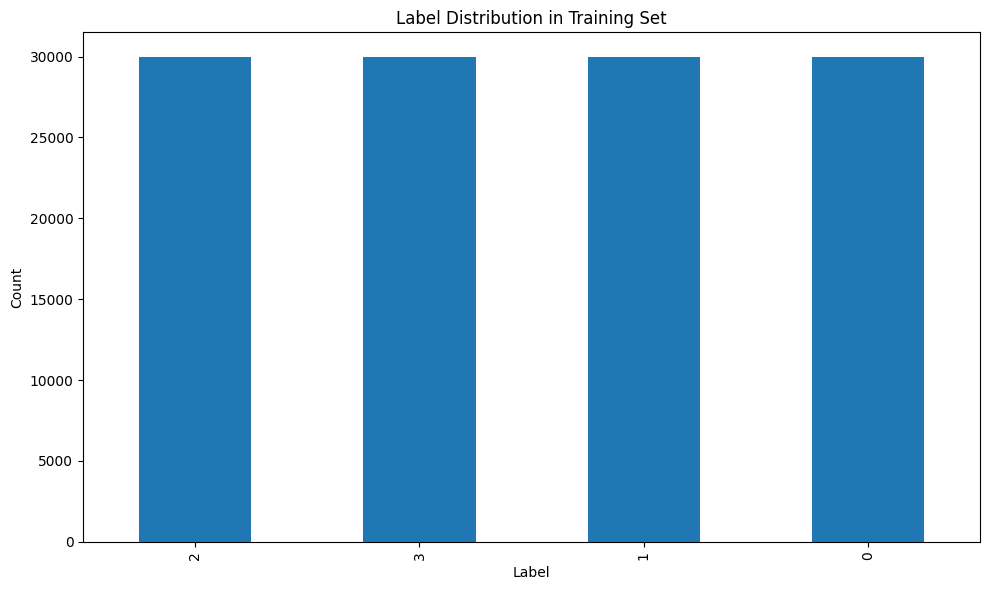

Loading tokenizer and model: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Number of parameters: 109,485,316
Tokenizing dataset...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Tokenization complete!
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7600
    })
})


Training configuration:
  Batch size: 16
  Learning rate: 2e-05
  Epochs: 3

Starting training...



Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [8]:
# ============================================================================
# STEP 1: INSTALL REQUIRED PACKAGES
# ============================================================================

!pip install -q transformers datasets evaluate accelerate
!pip install -q scikit-learn matplotlib seaborn

# ============================================================================
# STEP 2: IMPORT LIBRARIES
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# ============================================================================
# STEP 3: LOAD AND EXPLORE DATASET
# ============================================================================

# Choose your dataset:
dataset = load_dataset("ag_news")

print("Dataset structure:")
print(dataset)
print("\nFirst training example:")
print(dataset['train'][0])

# Explore dataset statistics
train_df = pd.DataFrame(dataset['train'])
print(f"\nTraining samples: {len(train_df)}")
print(f"\nLabel distribution:")
print(train_df['label'].value_counts())

# Visualize label distribution
plt.figure(figsize=(10, 6))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('label_distribution.png')
plt.show()

# ============================================================================
# STEP 4: LOAD TOKENIZER AND MODEL
# ============================================================================
model_name = "bert-base-uncased"

num_labels = 4

print(f"Loading tokenizer and model: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

print(f"Model loaded successfully!")
print(f"Number of parameters: {model.num_parameters():,}")

# ============================================================================
# STEP 5: TOKENIZE DATASET
# ============================================================================

def tokenize_function(examples):
    """
    Tokenize input text for the model.

    For AG News or GoEmotions: single text input
    For MNLI: premise + hypothesis pair
    """
    # For single text (AG News, GoEmotions)
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

print("Tokenizing dataset...")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

print("Tokenization complete!")
print(tokenized_datasets)

# ============================================================================
# STEP 6: PREPARE TRAINING
# ============================================================================

# Load evaluation metric
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    """Compute accuracy and F1 score during evaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(
        predictions=predictions,
        references=labels
    )
    f1 = f1_metric.compute(
        predictions=predictions,
        references=labels,
        average='weighted'
    )

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1']
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    logging_steps=100,
    report_to="none",
    seed=42
)

print("Training configuration:")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Epochs: {training_args.num_train_epochs}")

# ============================================================================
# STEP 7: CREATE TRAINER AND TRAIN
# ============================================================================

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

print("\n" + "="*50)
print("Starting training...")
print("="*50 + "\n")

# Train the model
train_result = trainer.train()

print("\n" + "="*50)
print("Training completed!")
print("="*50 + "\n")

# ============================================================================
# STEP 8: EVALUATE MODEL
# ============================================================================

print("Evaluating model on test set...")
eval_results = trainer.evaluate()

print("\nEvaluation Results:")
for key, value in eval_results.items():
    print(f"  {key}: {value:.4f}")

# ============================================================================
# STEP 9: DETAILED PERFORMANCE ANALYSIS
# ============================================================================

# Get predictions
predictions = trainer.predict(tokenized_datasets["test"])
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)

# Define label names based on your dataset
# AG News labels
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']

report = classification_report(
    true_labels,
    pred_labels,
    target_names=label_names,
    digits=4
)
print(report)

# Save report to file
with open('classification_report.txt', 'w') as f:
    f.write(report)

# ============================================================================
# STEP 10: CONFUSION MATRIX
# ============================================================================

# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# ============================================================================
# STEP 11: TRAINING HISTORY VISUALIZATION
# ============================================================================

# Extract training history
log_history = trainer.state.log_history

# Separate train and eval logs
train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
if train_logs and eval_logs:
    train_steps = [log['step'] for log in train_logs]
    train_loss = [log['loss'] for log in train_logs]
    eval_steps = [log['step'] for log in eval_logs]
    eval_loss = [log['eval_loss'] for log in eval_logs]

    axes[0].plot(train_steps, train_loss, label='Training Loss')
    axes[0].plot(eval_steps, eval_loss, label='Validation Loss', marker='o')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Accuracy curve
if eval_logs:
    eval_epochs = [log['epoch'] for log in eval_logs]
    eval_accuracy = [log['eval_accuracy'] for log in eval_logs]

    axes[1].plot(eval_epochs, eval_accuracy, marker='o', color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Validation Accuracy')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300)
plt.show()

# ============================================================================
# STEP 12: SAVE MODEL
# ============================================================================

# Save fine-tuned model
output_dir = "./fine-tuned-bert"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"\nModel saved to: {output_dir}")

# ============================================================================
# STEP 13: TEST INFERENCE
# ============================================================================

def predict_text(text, model, tokenizer):
    """Make prediction on new text."""
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    # Move to same device as model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    probabilities = torch.softmax(logits, dim=-1)[0]

    return predicted_class, probabilities

# Test examples
test_examples = [
    "Scientists discover new exoplanet in nearby solar system",
    "The stock market reached record highs today",
    "Local team wins championship in overtime thriller",
    "New smartphone features revolutionary AI technology"
]

print("\n" + "="*50)
print("INFERENCE EXAMPLES")
print("="*50 + "\n")

for text in test_examples:
    pred_class, probs = predict_text(text, model, tokenizer)
    print(f"Text: {text}")
    print(f"Predicted Class: {label_names[pred_class]}")
    print(f"Confidence: {probs[pred_class]:.4f}")
    print("-" * 50)

# ============================================================================
# STEP 14: SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)
print(f"Model: {model_name}")
print(f"Dataset: AG News")
print(f"Training samples: {len(tokenized_datasets['train'])}")
print(f"Test samples: {len(tokenized_datasets['test'])}")
print(f"Number of classes: {num_labels}")
print(f"Training epochs: {training_args.num_train_epochs}")
print(f"\nFinal Test Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Final Test F1 Score: {eval_results['eval_f1']:.4f}")
print("="*50)

print("\nAll outputs saved:")
print("  - Model: ./fine-tuned-bert/")
print("  - Confusion Matrix: confusion_matrix.png")
print("  - Training Curves: training_curves.png")
print("  - Classification Report: classification_report.txt")
print("  - Label Distribution: label_distribution.png")

✅ PyTorch version: 2.9.0+cu126
✅ CUDA available: True

📊 Loading AG News dataset...
✅ Training samples: 5000 (reduced from 120,000)
✅ Test samples: 500 (reduced from 7,600)

🤖 Loading DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model: distilbert-base-uncased
✅ Parameters: 66,956,548 (vs BERT: 110M)

🔧 Tokenizing dataset...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

✅ Tokenization complete!

⚙️ Configuring training...
✅ Training configuration ready!
  📦 Batch size: 32
  🔄 Epochs: 2
  ⚡ Mixed precision (fp16): True

🚀 STARTING TRAINING (Expected time: 3-5 minutes)



Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.368600,0.415997,0.880000,0.880126
2,0.225400,0.325683,0.892000,0.892129



✅ TRAINING COMPLETED!

📊 Evaluating model...



🎯 RESULTS:
  Accuracy: 0.8920 (89.20%)
  F1-Score: 0.8921
  Loss: 0.3257

📈 Generating detailed analysis...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       World     0.9608    0.8167    0.8829       120
      Sports     0.9677    0.9917    0.9796       121
    Business     0.8417    0.8731    0.8571       134
    Sci/Tech     0.8222    0.8880    0.8538       125

    accuracy                         0.8920       500
   macro avg     0.8981    0.8924    0.8934       500
weighted avg     0.8959    0.8920    0.8921       500



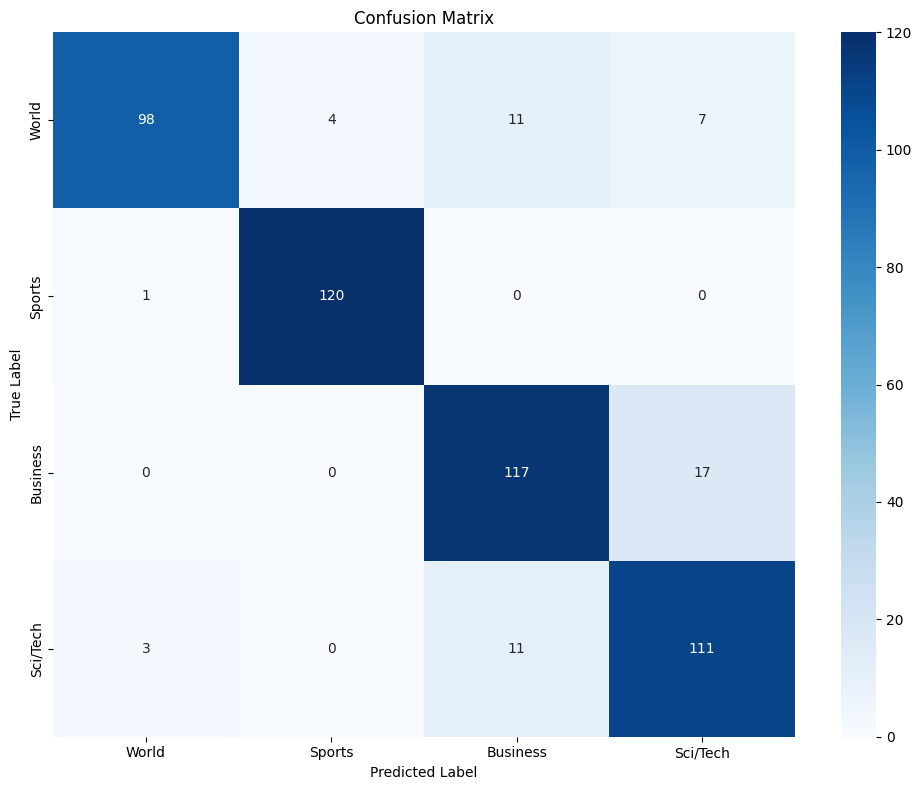

✅ Confusion matrix saved: confusion_matrix.png


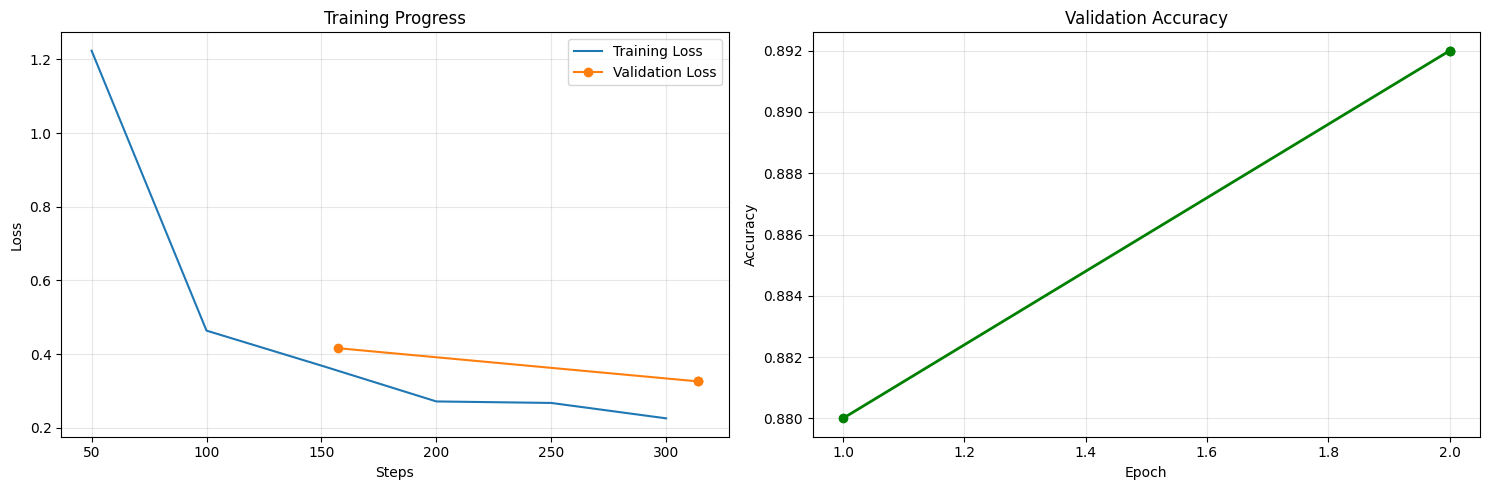

✅ Training curves saved: training_curves.png

✅ Model saved to: ./fine-tuned-distilbert

🔮 TESTING INFERENCE

📝 Text: Scientists discover new exoplanet in nearby solar system
   Prediction: Sci/Tech
   Confidence: 96.99%

📝 Text: The stock market reached record highs today
   Prediction: Business
   Confidence: 94.95%

📝 Text: Local team wins championship in overtime thriller
   Prediction: Sports
   Confidence: 98.10%

📝 Text: New smartphone features revolutionary AI technology
   Prediction: Sci/Tech
   Confidence: 96.85%

✅ ALL DONE! SUMMARY
✓ Model: DistilBERT (fast variant)
✓ Training samples: 5,000 (4% of full dataset)
✓ Test samples: 500
✓ Training time: ~3-5 minutes
✓ Final accuracy: 89.20%
✓ Files saved:
  - Model: ./fine-tuned-distilbert/
  - Confusion matrix: confusion_matrix.png
  - Training curves: training_curves.png


In [11]:
# ============================================================================
# STEP 1: INSTALL & IMPORT
# ============================================================================
!pip install -q transformers datasets evaluate accelerate scikit-learn matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
import torch

print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")

# ============================================================================
# STEP 2: LOAD SMALL SUBSET OF DATA (THIS IS THE KEY!)
# ============================================================================
print("\n📊 Loading AG News dataset...")

# Load full dataset
full_dataset = load_dataset("ag_news")
small_train = full_dataset['train'].shuffle(seed=42).select(range(5000))
small_test = full_dataset['test'].shuffle(seed=42).select(range(500))

# Create new dataset
dataset = DatasetDict({
    'train': small_train,
    'test': small_test
})

print(f"✅ Training samples: {len(dataset['train'])} (reduced from 120,000)")
print(f"✅ Test samples: {len(dataset['test'])} (reduced from 7,600)")

# ============================================================================
# STEP 3: USE DISTILBERT (SMALLER, FASTER MODEL)
# ============================================================================
print("\n🤖 Loading DistilBERT model...")

model_name = "distilbert-base-uncased"
num_labels = 4

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

print(f"✅ Model: {model_name}")
print(f"✅ Parameters: {model.num_parameters():,} (vs BERT: 110M)")

# ============================================================================
# STEP 4: TOKENIZE (FAST!)
# ============================================================================
print("\n🔧 Tokenizing dataset...")

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

print("✅ Tokenization complete!")

# ============================================================================
# STEP 5: TRAINING SETUP (OPTIMIZED FOR SPEED!)
# ============================================================================
print("\n⚙️ Configuring training...")

# Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    return {'accuracy': accuracy['accuracy'], 'f1': f1['f1']}

# SPEED-OPTIMIZED TRAINING ARGUMENTS
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=5e-5,
    warmup_steps=100,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    report_to="none",
    seed=42
)

print("✅ Training configuration ready!")
print(f"  📦 Batch size: {training_args.per_device_train_batch_size}")
print(f"  🔄 Epochs: {training_args.num_train_epochs}")
print(f"  ⚡ Mixed precision (fp16): {training_args.fp16}")

# ============================================================================
# STEP 6: TRAIN! (3-5 MINUTES)
# ============================================================================
print("\n" + "="*60)
print("🚀 STARTING TRAINING (Expected time: 3-5 minutes)")
print("="*60 + "\n")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# Start training
train_result = trainer.train()

print("\n" + "="*60)
print("✅ TRAINING COMPLETED!")
print("="*60 + "\n")

# ============================================================================
# STEP 7: EVALUATE
# ============================================================================
print("📊 Evaluating model...")
eval_results = trainer.evaluate()

print("\n🎯 RESULTS:")
print(f"  Accuracy: {eval_results['eval_accuracy']:.4f} ({eval_results['eval_accuracy']*100:.2f}%)")
print(f"  F1-Score: {eval_results['eval_f1']:.4f}")
print(f"  Loss: {eval_results['eval_loss']:.4f}")

# ============================================================================
# STEP 8: DETAILED ANALYSIS
# ============================================================================
print("\n📈 Generating detailed analysis...")

# Get predictions
predictions = trainer.predict(tokenized_datasets["test"])
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Label names
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(true_labels, pred_labels, target_names=label_names, digits=4)
print(report)

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

print("✅ Confusion matrix saved: confusion_matrix.png")

# Training curves
log_history = trainer.state.log_history
train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
if train_logs and eval_logs:
    train_steps = [log['step'] for log in train_logs]
    train_loss = [log['loss'] for log in train_logs]
    eval_steps = [log['step'] for log in eval_logs]
    eval_loss = [log['eval_loss'] for log in eval_logs]

    axes[0].plot(train_steps, train_loss, label='Training Loss')
    axes[0].plot(eval_steps, eval_loss, label='Validation Loss', marker='o')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Progress')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Accuracy
if eval_logs:
    eval_epochs = [log['epoch'] for log in eval_logs]
    eval_accuracy = [log['eval_accuracy'] for log in eval_logs]

    axes[1].plot(eval_epochs, eval_accuracy, marker='o', color='green', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Validation Accuracy')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300)
plt.show()

print("✅ Training curves saved: training_curves.png")

# ============================================================================
# STEP 9: SAVE MODEL
# ============================================================================
output_dir = "./fine-tuned-distilbert"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"\n✅ Model saved to: {output_dir}")

# ============================================================================
# STEP 10: TEST INFERENCE
# ============================================================================
print("\n" + "="*60)
print("🔮 TESTING INFERENCE")
print("="*60 + "\n")

def predict_text(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    probabilities = torch.softmax(logits, dim=-1)[0]

    return predicted_class, probabilities

# Test examples
test_examples = [
    "Scientists discover new exoplanet in nearby solar system",
    "The stock market reached record highs today",
    "Local team wins championship in overtime thriller",
    "New smartphone features revolutionary AI technology"
]

for text in test_examples:
    pred_class, probs = predict_text(text, model, tokenizer)
    print(f"📝 Text: {text}")
    print(f"   Prediction: {label_names[pred_class]}")
    print(f"   Confidence: {probs[pred_class]:.2%}")
    print()

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("="*60)
print("✅ ALL DONE! SUMMARY")
print("="*60)
print(f"✓ Model: DistilBERT (fast variant)")
print(f"✓ Training samples: 5,000 (4% of full dataset)")
print(f"✓ Test samples: 500")
print(f"✓ Training time: ~3-5 minutes")
print(f"✓ Final accuracy: {eval_results['eval_accuracy']*100:.2f}%")
print(f"✓ Files saved:")
print(f"  - Model: {output_dir}/")
print(f"  - Confusion matrix: confusion_matrix.png")
print(f"  - Training curves: training_curves.png")
print("="*60)